In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras

In [2]:
def relu(Z):
    """Implements the RELU activation elementwise.

    Args:
        Z: Numpy array of arbitrary shape.

    Returns:
        A: Output of RELU function given Z.
    """
    
    A = np.maximum(0, Z)
    
    return A

def relu_gradient(Z):
    """Computes the gradient of the RELU activation.

    Args:
        Z: Numpy array of arbitrary shape.
        
    Returns:
        dz: Gradient of the RELU function with respect to Z.
    """
    
    dz = np.zeros((Z.shape))
    dz[Z > 0] = 1
    
    return dz

def softmax(Z):
    """Computes the softmax function for each column of Z.
    
    Args:
        Z: Numpy array of arbitrary shape.
    
    Returns:
        S: Output of the softmax function given Z.
    """
    Z_exp = np.exp(Z)
    Z_column_sum = np.sum(Z_exp, axis=0, keepdims=True)
    S = Z_exp/Z_column_sum
    
    return S

def one_hot_encoding(Y, C):
    """Implements one hot encoding to label vector.
    
    Args:
        Y: Label vector of shape (number of classes, number of examples). 
        C: Number of labels to classify.
        
    Returns:
        e: One hot encoding of label vector.
    """
    e = np.zeros((Y.size, C))
    e[np.arange(Y.size), Y] = 1
    e = e.T
    
    return e

In [3]:
def init_params(layer_sizes):
    """Initializes weight and bias parameters for each network layer.
    
    Args:
        layer_sizes: A list containing the size of each network layer.
        
    Returns:
        params: A dict mapping keys to the corresponding network parameters.
    """
    
    params = dict()
    L = len(layer_sizes) # number of layers including input layer
    
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_sizes[l], layer_sizes[l - 1]) / np.sqrt(layer_sizes[l - 1])  # weight matrix
        params['b' + str(l)] = np.zeros((layer_sizes[l], 1)) # bias vector
    
    return params

In [4]:
def forw_prop_l(W, A_prev, b, activation):
    """Implements the forward propagation computation for layer l.
    
    Args:
        W: Weight matrix of current layer with dimension (size of current layer, size of previous layer).
        A_prev: Activation matrix of previous layer with dimension (size of previous layer, number of examples) ).
        b: Bias vector of current layer with dimension (size of current layer, 1).
        activation: Activation function. 
    
    Returns:
        A: Output of the activation function.
        cache: A tuple containing 'W', 'A_prev', 'b' and 'Z' to be used for the backward propagation.
    """
    
    Z = np.dot(W, A_prev) + b # computes pre-activation parameter Z
    A = activation(Z)
    cache = (W, A_prev, b, Z)
    
    return A, cache

In [5]:
def forward_propagation(params, X, activation_hidden, activation_output):
    """Implements the forward propagation computation for the network and outputs predictions vector.
    
    Args:
        X: Data of dimension (number of input features, number of examples)
        params: A dict mapping keys to the corresponding network parameters.
        
    Returns:
        A: Output of the activation function of the output layer.
        caches: A list of caches containing every cache of forw_prop_l function.
    """
    
    L = len(params) // 2 # number of layers in the network excluding input layer
    A = X
    caches = []
    
    for l in range(1, L + 1):
        A, cache = forw_prop_l(params['W' + str(l)], A, params['b' + str(l)], activation_output if l == L else activation_hidden)
        caches.append(cache)
        
    return A, caches

In [6]:
def cross_entropy_cost(Y_hat, Y):
    """Implements the cross-entropy cost function.
    
    Args:
        Y_hat: Probability vector corresponding to class predictions of shape (number of classes, number of examples).
        Y: Ground truth vector of shape (number of classes, number of examples).
        
    Returns:
        cost: Cross-entropy cost.
    """
    
    m = Y.shape[1] # number of examples
    
    cost = -np.sum(np.multiply(Y, np.log(Y_hat)))
    cost = np.squeeze(cost) # transform the cost from the shape of an array into the shape of a scalar
    
    return cost

In [7]:
def backw_prop(cache, dA, activation_backward):
    """Implements the backward propagation computation for layer l.
    
    Args:
        cache: The cache output (W, A_prev, b, Z) of forw_prop function called for current layer l.
        dA: Gradient of the cost with respect to the activation of current layer l.
        activation_backward: A function computing the gradient of activation function with respect to its input.
        
    Returns: 
        dA_prev: Gradient of the cost with respect to the activation of the previous layer.
        dW: Gradient of the cost with respect to weight parameter of current layer l.
        db: Gradient of the cost with respect to bias parameter of current layer l.
    """
    
    W, A_prev, b, Z = cache
    m = A_prev.shape[1]
    
    dZ = dA * activation_backward(Z)
    dA_prev = np.dot(W.T, dZ)
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    
    return dA_prev, dW, db

In [8]:
def backward_propagation(caches, Y_hat, Y, hidden_activation_backward):
    """Implements the backward propagation computation for the network.
    
    Args:
        caches: A list of caches which are the outputs of forw_prop functions for every layer l.
        Y_hat: Probability vector corresponding to class predictions of shape (number of classes, number of examples).
        Y: Ground truth matrix of shape (number of classes, number of examples).
        
    Returns:
        grads: A dict mapping keys to the corresponding gradients of the network.
    """
    
    grads = dict()
    m = Y.shape[1]
    L = len(caches) # number of layers excluding input layer
    Y.reshape(Y_hat.shape)
    
    # computes gradient of the cost with respect to Y_hat to initialize backward propagation.
    W, A_prev, b, Z = caches[L - 1]
    dZ = Y_hat - Y
    dA_prev = np.dot(W.T, dZ)
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db
    
    for l in reversed(range(L - 1)):
        cache_current = caches[l]
        gradients = backw_prop(cache_current, grads["dA" + str(l + 1)], hidden_activation_backward)
        (grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)]) = gradients
                                                              
    return grads

In [9]:
def update_params(params, grads, alpha):
    """Updates network parameters using gradient descent algorithm.
    
    Args:
        params: A dict mapping keys to the corresponding network parameters.
        grads: A dict mapping keys to the corresponding gradients of the network.
        alpha: Learning rate of the gradient descent algorithm.
        
    Returns:
        params: A dict mapping keys to the corresponding updated network parameters.
    """
    
    L = len(params) // 2 # number of layers excluding input layer
    
    for l in range(L):
        params['W' + str(l + 1)] = params['W' + str(l + 1)] - alpha * grads['dW' + str(l + 1)]
        params['b' + str(l+1)] = params['b' + str(l + 1)] - alpha * grads['db' + str(l + 1)]
        
    return params


In [10]:
def flatten(data):
    """ Flattens a multi-dimensional array except its first dimension corresponding to number of example.""" 
    
    return data.reshape(data.shape[0], -1)

In [11]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [12]:
X_train = flatten(X_train) / 255
X_test = flatten(X_test) / 255
layer_sizes = [784, 10, 10, 20, 10]

In [13]:
def mini_batches(X, Y, mini_batch_size = 128):
    """Creates a list of random minibatches from (X, Y).
    
    Args:
        X: Input data of shape (number of input features, number of examples).
        Y: Ground truth vector of shape (1, number of examples).
        mini_batch_size: Size of mini-batches.
    
    Returns:
        mini_batches: A list of mini-batches.
    """
    
    m = X.shape[1] # number of training examples
    mini_batches = []
        
    # shuffles (X, Y)
    permute = np.random.permutation(m)
    X, Y = X[:, permute], Y[:, permute]
    Y = Y
    
    # partition (X, Y)
    n = m // mini_batch_size # number of mini batches of size mini_batch_size 
    for k in range(n):
        mini_batch_X = X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    if m % mini_batch_size:
        mini_batch_X = X[:, n * mini_batch_size :]
        mini_batch_Y = Y[:, n * mini_batch_size :]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

In [14]:
def predict(X, Y, params):
    """Implements forward propagation on a test set and makes predictions.
    
    Args:
        X: Data of shape (number of input features, number of examples)
        Y: Ground truth vector of shape (1, number of examples)
        params: Network parameters learnt by the model.
    
    Returns:
        accuracy: An amount of correct predictions as percentage.
        predicted: A vector of predicted labels of shape (1, number of examples).
    """
    
    m = X.shape[1]
    A, caches = forward_propagation(params, X, relu, softmax)
    
    predicted = np.argmax(A, axis=0).reshape(Y.shape)
    
    accuracy = np.mean(predicted == Y)
    
    return accuracy, predicted

In [17]:
def model(X, Y, X_test, Y_test, layer_sizes, mini_batch_size = 32, alpha = 0.005, epochs = 20):
    """Implements a deep neural network.
    
    Args:
        X: Data of shape (number of input features, number of examples)
        Y: Ground truth vector of shape (1, number of examples)
        layer_sizes: A list containing the size of each network layer.
        alpha: Learning rate of the gradient descent algorithm.
        epochs: Number of passes through whole training data
        
    Returns:
        params: Network parameters learnt by the model.
    """
    
    X = X.T # stacks examples in columns
    m = X.shape[1]
    Y = Y.reshape(1, m)
    costs = []
    
    params = init_params(layer_sizes)
    
    for epoch in range(epochs):
        
        minibatches = mini_batches(X, Y, mini_batch_size)
        total_cost = 0
        
        for minibatch in minibatches:
            minibatch_X, minibatch_Y = minibatch
            minibatch_Y = one_hot_encoding(minibatch_Y, 10)
            
            Y_hat, caches = forward_propagation(params, minibatch_X, relu, softmax)
            total_cost += cross_entropy_cost(Y_hat, minibatch_Y)
            grads = backward_propagation(caches, Y_hat, minibatch_Y, relu_gradient)
            params = update_params(params, grads, alpha)
        
        cost = total_cost / m
        accuracy, prediction = predict(X_test.T, Y_test.reshape(1, Y_test.size), params)
        if epoch % 1 == 0:
            print ("Cost and Accuracy after iteration %i: %f, %a" %(epoch, cost, accuracy))
            costs.append(cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    
    return params

Cost and Accuracy after iteration 0: 1.862017, 0.5833
Cost and Accuracy after iteration 1: 0.825778, 0.8395
Cost and Accuracy after iteration 2: 0.497034, 0.8715
Cost and Accuracy after iteration 3: 0.425149, 0.8831
Cost and Accuracy after iteration 4: 0.389593, 0.8927
Cost and Accuracy after iteration 5: 0.365237, 0.8976
Cost and Accuracy after iteration 6: 0.344245, 0.9033
Cost and Accuracy after iteration 7: 0.326045, 0.9079
Cost and Accuracy after iteration 8: 0.310653, 0.9107
Cost and Accuracy after iteration 9: 0.297661, 0.9105
Cost and Accuracy after iteration 10: 0.288059, 0.9165
Cost and Accuracy after iteration 11: 0.279085, 0.9186
Cost and Accuracy after iteration 12: 0.271073, 0.9165
Cost and Accuracy after iteration 13: 0.265723, 0.9222
Cost and Accuracy after iteration 14: 0.260562, 0.9228
Cost and Accuracy after iteration 15: 0.255411, 0.9196
Cost and Accuracy after iteration 16: 0.250755, 0.9227
Cost and Accuracy after iteration 17: 0.246163, 0.9255
Cost and Accuracy af

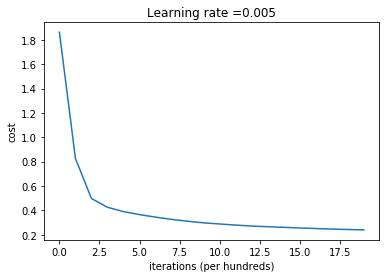

In [18]:
params = model(X_train, Y_train, X_test, Y_test, layer_sizes)